## STTMALST Gastrointestinal-Cancer-MSI-MSS-Prediction TRANSFER LEARNING ATTEMPT 

This notebook tries to attempt what did not work when trying to create a CNN with such a large dataset running on a single computer.<br> 
Here the entire notebook will be heavily inspired by: https://www.tensorflow.org/tutorials/images/transfer_learning, which explains how to <br>
use transfer learning to create a base model from the ModelNet V2 created by google. Here we will explore if transfer learning proves to be a better <br>
alternative to a CNN which took over 7 hours to run. Some items in this notebook reuses code from the CNN notebook. 

Reference list and inspriation links:<br>

https://www.tensorflow.org/tutorials/load_data/images<br>
https://www.tensorflow.org/api_docs/python/tf/data/Dataset#top_of_page  <br>
https://www.tensorflow.org/tutorials/images/classification<br>
https://www.kaggle.com/linjustin/cnn-keras
https://www.tensorflow.org/tutorials/images/transfer_learning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pathlib 

from time import time
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
#GLOBAL VALUES
batch_size = 128
img_size = (224,224)
img_shape = img_size + (3,)
epochs = 10

In [3]:
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print("Tensorflow version: ",tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print(device_lib.list_local_devices())

Tensorflow version:  2.5.0-dev20201217
Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 950972908158536769
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5845129625
locality {
  bus_id: 1
  links {
  }
}
incarnation: 393837148333882341
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [4]:
DATA_PATH = './tcga_coad_msi_mss'
data_dir = pathlib.Path(DATA_PATH)

training_set_dir = os.path.join(DATA_PATH, 'train')
training_root = pathlib.Path(training_set_dir)

test_set_dir = os.path.join(DATA_PATH, 'test')
test_root = pathlib.Path(test_set_dir)

validation_set_dir = os.path.join(DATA_PATH,'val')
validation_root = pathlib.Path(validation_set_dir)

In [5]:
#Train dataset
train_ds = image_dataset_from_directory(training_root,
 seed=222,
  image_size=img_size,
   batch_size=batch_size,
    shuffle=True)

#Test dataset
test_ds = image_dataset_from_directory(test_root,
 seed=222,
  image_size=img_size,
   batch_size=batch_size,
    shuffle=True)

#Validation dataset
val_ds = image_dataset_from_directory(validation_root,
 seed=222,
  image_size=img_size,
   batch_size=batch_size,
    shuffle=True)

Found 153849 files belonging to 2 classes.
Found 19233 files belonging to 2 classes.
Found 19230 files belonging to 2 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['MSIMUT', 'MSS']


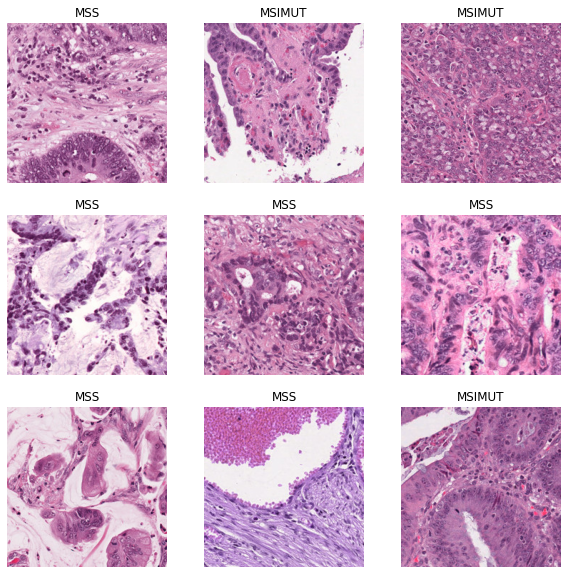

In [7]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of train batches: 1202
Number of validation batches: 151
Number of test batches: 151


In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

image_batch_numpy = image_batch.numpy()
labels_batch_numpy = labels_batch.numpy()
print('Training data: Minimum RGB value for batch: %.3f, Maximum RGB value: %.3f' % (image_batch_numpy.min(), image_batch_numpy.max()))

(128, 224, 224, 3)
(128,)
Training data: Minimum RGB value for batch: 0.000, Maximum RGB value: 255.000


## Introducing the _MobileNetV2_ base model
This model is pre-trained on the ImageNet Dataset, which is a famous dataset containing over 1.4 million images and 1000 classes. <br>
The classes in the data are real world items, which could prove to be useless in this case meaning that another pre-trained model<br>
used on a different dataset might be necessary to gain accurate results <-- This is reviewed froim here and forward.

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# height, width and color channels needed to gain a correct image shape
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')


In [12]:
#feature extractor: converts image shape (224,224,3) into feature blocks
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(128, 7, 7, 1280)


When training we need to ensure that the base model is not trained with the model.<br> 
Here we need weights in every layer of the base model to stay the same and not be updated

In [13]:
base_model.trainable = False
base_model.summary()

xpand_relu[0][0]        
__________________________________________________________________________________________________
block_6_depthwise (DepthwiseCon (None, 14, 14, 192)  1728        block_6_pad[0][0]                
__________________________________________________________________________________________________
block_6_depthwise_BN (BatchNorm (None, 14, 14, 192)  768         block_6_depthwise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 14, 14, 192)  0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 14, 14, 64)   12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 14, 14, 64)   256         block_6_project[0][

In [14]:
# Classification head, averages over the 7x7 spatial locations in the feature batch object creating a 1280-element vector pr image.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(128, 1280)


In [15]:
# Convering each feature in the average feature batch object into a single prediction pr image
# All positive numbers predict class 1 and all negative numbers predict class 0.
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(128, 1)


## Training the model

In [16]:
input_values = tf.keras.Input(shape=img_shape)
#x = data_augmentation(input_values)
x = preprocess_input(input_values)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_values = prediction_layer(x)
model = tf.keras.Model(input_values, output_values)


In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281  

In [18]:
print('evaluation validation set')
start = time()
loss0, accuracy0 = model.evaluate(val_ds)

end = time()
time_elapsed = end - start
print('\nvalidation evaludation time took {:.0f}h {:.0f}m {:.0f}s. with 601 batches'.format(time_elapsed//(60*60),
                                                        time_elapsed//60, 
                                                        time_elapsed % 60))

evaluation validation set
151/151 [==============================] - 458s 3s/step - loss: 0.7515 - accuracy: 0.4956

validation evaludation time took 0h 7m 42s. with 601 batches


In [19]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.75
initial accuracy: 0.49


In [ ]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_ds)
